In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

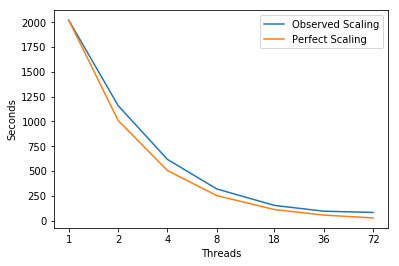

In [3]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads,[2020.0, 1160.0, 617.5, 320.0, 153.88888888888889, 95.83333333333333, 83.33333333333333],
        label='Observed Scaling')
ax.plot(Threads, [2020.0, 1010.0, 505.0, 252.5, 112.22222222222223, 56.111111111111114, 28.055555555555557],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Intel Software Development Emulator !! Update
| SDE Metrics | miniAero |
|:-----------|:---:|
| **Arithmetic Intensity** | 0.08 |
| **Bytes per Load Inst** | 8.35 |
| **Bytes per Store Inst** | 9.56 |

---
## Roofline  -  Intel(R) Xeon(R) CPU E5-2699 v3 @ 2.30GHz  !!!UPDATE
### 72 Threads - 36 - Cores 2300.0 Mhz
|     GB/sec     |  L1 B/W |  L2 B/W |  L3 B/W | DRAM B/W |
|:---------------|:-------:|:-------:|:-------:|:--------:|
|**1 Thread**  | 143.1 |  44.87 | 33.12 |   16.04  |
|**36 Threads**  | 2509.07 |  807.72 | 558.03 |   58.38  |
|**72 Threads**  | 2391.14 |  792.13 | 581.89 |   42.97  |

---
### Experiment Aggregate Metrics

 |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized | DRAM B/W Utilized
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (100.0%)|0.86|0.28|0.38|3.39%|30.81%|59.64%|5.26%|6.49%| 1.96%|
|36 (100.0%)|0.75|0.26|0.35|2.30%|29.65%|62.89%|6.49%|8.63%|13.10%|
|72 (100.0%)|0.95|0.17|0.23|4.49%|29.64%|41.40%|8.69%|9.39%|2.30%|

### limiter_face stincilLimiter.h (352)
```c++
352 /* limiter_face
353  * functor that computes the limiter value for each face and scatter contribution
354  * to the connected elements.  Uses gather-sum or atomics for thread safety.
355  */
356 template <class Device, bool interior>
357 struct limiter_face{
358   typedef Device device_type;
359   typedef typename ViewTypes<Device>::c_rnd_scalar_field_type scalar_field_type;
360   typedef typename ViewTypes<Device>::c_rnd_solution_field_type solution_field_type;
361   typedef typename ViewTypes<Device>::c_rnd_face_cell_conn_type face_cell_conn_type;
362   typedef typename ViewTypes<Device>::c_rnd_vector_field_type vector_field_type;
363   typedef typename ViewTypes<Device>::cell_storage_field_type cell_storage_field_type;
364   typedef typename ViewTypes<Device>::c_rnd_gradient_field_type gradient_field_type;
365 
366   scalar_field_type cell_volumes_;
367   face_cell_conn_type face_cell_conn_;
368   face_cell_conn_type cell_flux_index_;
369   solution_field_type cell_min_, cell_max_, cell_values_;
370   vector_field_type face_coordinates_, cell_coordinates_;
371   gradient_field_type cell_gradients_;
372   cell_storage_field_type limiter_;
373   Kokkos::View<const int*, Device> permute_vector_;
374 
375   limiter_face(Faces<Device> faces, solution_field_type cell_values, Cells<Device> cells,
376     gradient_field_type gradients,
377     solution_field_type cell_min, solution_field_type cell_max, cell_storage_field_type limiter):
378     face_cell_conn_(faces.face_cell_conn_),
379     cell_flux_index_(faces.cell_flux_index_),
380     cell_min_(cell_min),
381     cell_max_(cell_max),
382     cell_values_(cell_values),
383     face_coordinates_(faces.coordinates_),
384     cell_coordinates_(cells.coordinates_),
385     cell_gradients_(gradients),
386     limiter_(limiter),
387     permute_vector_(faces.permute_vector_)
388   {}
389 
```

| Threads (Time) | IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (13.7%)|0.71|0.29|0.35|3.41%|34.77%|51.51%|4.31%|5.78%|2.53%|
|36 (10.9%)|0.52|0.21|0.25|3.99%|36.13%|61.69%|7.18%|9.86%|27.48%|
|72 (10.6%)|0.64|0.12|0.14|8.50%|38.18%|44.97%|9.13%|10.46%|5.73%|

```c++
390 KOKKOS_INLINE_FUNCTION
391 void operator()( const int& ii )const{
392   const int i = permute_vector_(ii);
393   const int left_index = face_cell_conn_(i,0);
394   const int right_index = face_cell_conn_(i,1);
395 
396   double conservatives_l[5];
397         double conservatives_r[5];
398   double primitives_l[5];
399   double primitives_r[5];
400 
401   for (int icomp = 0; icomp < 5; ++icomp)
402   {
403     if(interior){
404       conservatives_l[icomp] = cell_values_(left_index,icomp);
405       conservatives_r[icomp] = cell_values_(right_index,icomp);
406     }
407     else{
408       conservatives_l[icomp] = cell_values_(left_index,icomp);
409     }
410   }
411 
412   if(interior){
413     ComputePrimitives<device_type>(conservatives_l, primitives_l);
414     ComputePrimitives<device_type>(conservatives_r, primitives_r);
415   }
416   else{
417     ComputePrimitives<device_type>(conservatives_l, primitives_l);
418   }
419 
420 //Compute left limiter value and compute right limiter value
421 
422   double limiter_left[5], limiter_right[5];
423   //compute displacement and distance from cell center to face center.
424   double displacement_l[3];
425   double displacement_r[3];
426   double distance_l = 0;
427   double distance_r = 0;
428   for(int idir = 0; idir < 3; ++idir){
429     displacement_l[idir] = face_coordinates_(i, idir)-cell_coordinates_(left_index, idir);
430     distance_l += displacement_l[idir]*displacement_l[idir];
431     if(interior){
432       displacement_r[idir] = face_coordinates_(i, idir)-cell_coordinates_(right_index, idir);
433       distance_r += displacement_r[idir]*displacement_r[idir];
434       }
435   }
436 
437   double dU_l[5];
438   double dU_r[5];
439   //Extrapolation
440   for(int icomp = 0; icomp < 5; ++icomp){
441     dU_l[icomp] = 0;
442     dU_r[icomp] = 0;
443     for(int idir = 0; idir < 3; ++idir){
444       dU_l[icomp] += displacement_l[idir]*cell_gradients_(left_index, icomp, idir);
445       if(interior)
446         dU_r[icomp] += displacement_r[idir]*cell_gradients_(right_index, icomp, idir);
447     }
448   }
449 
450 
451   for(int icomp = 0; icomp < 5; ++icomp){
452     double dumax_l = cell_max_(left_index, icomp) - primitives_l[icomp];
453     double dumin_l = cell_min_(left_index, icomp) - primitives_l[icomp];
454 
455     limiter_left[icomp] = VenkatLimiter<device_type>::limit(dumax_l, dumin_l, dU_l[icomp], distance_l);
456     if(interior){
457       double dumax_r = cell_max_(right_index, icomp) - primitives_r[icomp];
458       double dumin_r = cell_min_(right_index, icomp) - primitives_r[icomp];
459       limiter_right[icomp] = VenkatLimiter<device_type>::limit(dumax_r, dumin_r, dU_r[icomp], distance_r);
460     }
461   }
462 
463 //Then write to memory
464 #ifdef ATOMICS_FLUX
465   for (int icomp = 0; icomp < 5; ++icomp)
466   {
467     double * left_cell_limiter = &limiter_(left_index,0,icomp);
468     bool success=false;
469     do{
470       double old_left_limiter =  *left_cell_limiter;
471       double new_left_limiter = MathTools<device_type>::min(*left_cell_limiter, limiter_left[icomp]);
472       double new_value = Kokkos::atomic_compare_exchange(left_cell_limiter, old_left_limiter, new_left_limiter);
473       success = new_value == new_left_limiter;
474     } while(!success);
475 
476     if(interior){
477       double * right_cell_limiter = &limiter_(right_index,0,icomp);
478       success=false;
479       do{
480         double old_right_limiter =  *right_cell_limiter;
481         double new_right_limiter = MathTools<device_type>::min(*right_cell_limiter, limiter_right[icomp]);
482         double new_value = Kokkos::atomic_compare_exchange(right_cell_limiter, old_right_limiter, new_right_limiter);
483         success = new_value == new_right_limiter;
484       } while(!success);
485     }
486   }
487 #endif
488 
489 #ifdef CELL_FLUX
490 for (int icomp = 0; icomp < 5; ++icomp)
491 {
492   limiter_(left_index, cell_flux_index_(i,0), icomp) = limiter_left[icomp];
493 
494   if(interior){
495     limiter_(right_index, cell_flux_index_(i,1), icomp) = limiter_right[icomp];
496   }
497 }
498 #endif
499 }
```

compute_face_flux flux.h(90ish)



```c++
 43 /* compute_face_flux
 44  * functor to compute the internal face flux contributions.
 45  * Uses the templated Inviscid and Inviscid flux types to
 46  * compute the contribution. This functor organizes
 47  * the data to pass to the functions that compute the flux
 48  * and puts the flux contribution in the appropriate place
 49  * using either Gather-Sum or Atomics for thread safety.
 50  */
 51 
 52 template<class Device, bool second_order, class InviscidFluxType,
 53     class ViscousFluxType>
 54 struct compute_face_flux {
 55   typedef Device device_type;
 56   typedef typename ViewTypes<Device>::c_rnd_solution_field_type solution_field_type;
 57   typedef typename ViewTypes<Device>::c_rnd_face_cell_conn_type face_cell_conn_type;
 58   typedef typename ViewTypes<Device>::cell_storage_field_type cell_storage_field_type;
 59   typedef typename ViewTypes<Device>::c_vector_field_type vector_field_type;
 60   typedef typename ViewTypes<Device>::c_rnd_gradient_field_type gradient_field_type;
 61 
 62   face_cell_conn_type face_cell_conn_;
 63   face_cell_conn_type cell_flux_index_;
 64   solution_field_type cell_values_;
 65   gradient_field_type cell_gradients_;
 66   solution_field_type cell_limiters_;
 67   vector_field_type cell_coordinates_;
 68   cell_storage_field_type cell_flux_;
 69   vector_field_type face_coordinates_, face_normal_, face_tangent_,
 70       face_binormal_;
 71   Kokkos::View<const int*, Device> permute_vector_;
 72   InviscidFluxType inviscid_flux_evaluator_;
 73   ViscousFluxType viscous_flux_evaluator_;
 74 
 75 
 76   compute_face_flux(Faces<Device> faces, solution_field_type cell_values,
 77       gradient_field_type cell_gradients, solution_field_type cell_limiters,
 78       Cells<Device> cells, InviscidFluxType inviscid_flux,
 79       ViscousFluxType viscous_flux) :
 80       face_cell_conn_(faces.face_cell_conn_), cell_flux_index_(
 81           faces.cell_flux_index_), cell_values_(cell_values), cell_gradients_(
 82           cell_gradients), cell_limiters_(cell_limiters), cell_coordinates_(
 83           cells.coordinates_), cell_flux_(cells.cell_flux_), face_coordinates_(
 84           faces.coordinates_), face_normal_(faces.face_normal_), face_tangent_(
 85           faces.face_tangent_), face_binormal_(faces.face_binormal_), inviscid_flux_evaluator_(
 86           inviscid_flux), viscous_flux_evaluator_(viscous_flux) , permute_vector_(faces.permute_vector_) {
 87   }
 88 
 ```
 
 | Threads (Time) | IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (28.5%)|1.05|0.40|0.55|2.01%|36.06%|68.69%|3.59%|4.76%|3.41%|
|36 (22.3%)|0.79|0.31|0.42|2.03%|35.41%|76.47%|5.26%|7.30%|29.80%|
|72 (20.8%)|1.00|0.19|0.25|4.60%|34.48%|65.50%|7.70%|9.18%|5.62%|
 
 ```c++
 89   KOKKOS_INLINE_FUNCTION
 90   void operator()(const int& ii) const {
 91     const int i = permute_vector_(ii);
 92     const int left_index = face_cell_conn_(i, 0);
 93     const int right_index = face_cell_conn_(i, 1);
 94 
 95     double flux[5];
 96     double conservatives_l[5];
 97     double conservatives_r[5];
 98     double primitives_l[5];
 99     double primitives_r[5];
100 
101     for (int icomp = 0; icomp < 5; ++icomp) {
102       conservatives_l[icomp] = cell_values_(left_index, icomp);
103       conservatives_r[icomp] = cell_values_(right_index, icomp);
104     }
105 
106     ComputePrimitives<device_type>(conservatives_l, primitives_l);
107     ComputePrimitives<device_type>(conservatives_r, primitives_r);
108 
109     if (second_order) {
110 
111       //Extrapolation
112       for (int icomp = 0; icomp < 5; ++icomp) {
113         double gradient_primitive_l_tmp = 0;
114               double gradient_primitive_r_tmp = 0;
115 
116         for (int idir = 0; idir < 3; ++idir) {
117             gradient_primitive_l_tmp += (face_coordinates_(i, idir)
118                 - cell_coordinates_(left_index, idir))
119                           * cell_gradients_(left_index, icomp, idir);
120 
121             gradient_primitive_r_tmp += (face_coordinates_(i, idir)
122                           - cell_coordinates_(right_index, idir))
123                           * cell_gradients_(right_index, icomp, idir);
124         }
125 
126         primitives_l[icomp] += gradient_primitive_l_tmp *
127                 cell_limiters_(left_index, icomp);
128         primitives_r[icomp] += gradient_primitive_r_tmp *
129                 cell_limiters_(right_index, icomp);
130       }
131 
132     } // End of second order
133 
134 
135     inviscid_flux_evaluator_.compute_flux(primitives_l, primitives_r, flux,
136         &face_normal_(i,0), &face_tangent_(i,0), &face_binormal_(i,0));
137 
138     if (ViscousFluxType::isViscous) {
139       double primitives_face[5];
140       double gradients_face[5][3];
141 
142       for (int icomp = 0; icomp < 5; ++icomp) {
143         primitives_face[icomp] = 0.5
144             * (primitives_l[icomp] + primitives_r[icomp]);
145 
146         for (int idir = 0; idir < 3; ++idir) {
147           gradients_face[icomp][idir] = 0.5
148               * (cell_gradients_(left_index, icomp, idir)
149                   + cell_gradients_(right_index, icomp, idir));
150         }
151       }
152 
153       double vflux[5];
154       viscous_flux_evaluator_.compute_flux(gradients_face, primitives_face,
155           &face_normal_(i,0), vflux);
156 
157       for (int icomp = 0; icomp < 5; ++icomp) {
158         flux[icomp] -= vflux[icomp];
159       }
160     }
161 
162 #ifdef ATOMICS_FLUX
163     for (int icomp = 0; icomp < 5; ++icomp)
164     {
165       double * left_cell = &cell_flux_(left_index,0,icomp);
166       Kokkos::atomic_add(left_cell, -flux[icomp]);
167       double * right_cell = &cell_flux_(right_index,0,icomp);
168       Kokkos::atomic_add(right_cell, flux[icomp]);
169     }
170 #endif
171 
172 #ifdef CELL_FLUX
173     for (int icomp = 0; icomp < 5; ++icomp)
174     {
175       cell_flux_(left_index,cell_flux_index_(i,0),icomp) = -flux[icomp];
176       cell_flux_(right_index,cell_flux_index_(i,1),icomp) = flux[icomp];
177     }
178 #endif
179 
180   }
181 
182 };

```

green_guass_face GreenGauss.h (79)
```c++
 47 /*green_gauss_face
 48  * functor to compute internal face contributions for Green-Gauss gradient computation.
 49  */
 50 
 51 template <class Device>
 52 struct green_gauss_face{
 53   typedef Device device_type;
 54   typedef typename ViewTypes<Device>::c_rnd_scalar_field_type scalar_field_type;
 55   typedef typename ViewTypes<Device>::c_rnd_solution_field_type solution_field_type;
 56   typedef typename ViewTypes<Device>::c_rnd_face_cell_conn_type face_cell_conn_type;
 57   typedef typename ViewTypes<Device>::c_rnd_vector_field_type vector_field_type;
 58   typedef typename ViewTypes<Device>::gradient_storage_field_type gradient_storage_field_type;
 59 
 60   scalar_field_type cell_volumes_;
 61   face_cell_conn_type face_cell_conn_;
 62   face_cell_conn_type cell_flux_index_;
 63   solution_field_type cell_values_;
 64   gradient_storage_field_type cell_gradient_;
 65   vector_field_type face_normal_;
 66   Kokkos::View<const int*, Device> permute_vector_;
 67 
 68   green_gauss_face(Faces<Device> faces, solution_field_type cell_values, Cells<Device> cells):
 69     cell_volumes_(cells.volumes_),
 70     face_cell_conn_(faces.face_cell_conn_),
 71     cell_flux_index_(faces.cell_flux_index_),
 72     cell_values_(cell_values),
 73     cell_gradient_(cells.cell_gradient_),
 74     face_normal_(faces.face_normal_),
 75     permute_vector_(faces.permute_vector_)
 76   {}
 77 
 78 KOKKOS_INLINE_FUNCTION
 79 void operator()( const int& ii )const{
 80     const int i = permute_vector_(ii);
 81     const int left_index = face_cell_conn_(i,0);
 82     const int right_index = face_cell_conn_(i,1);
 83 
 84     const double gamma = 1.4;
 85     const double Rgas = 287.05;
 86 
 87     const double left_r  = cell_values_(left_index, 0);
 88     const double left_ri = 1.0 / left_r;
 89     const double left_u  = cell_values_(left_index, 1) * left_ri;
 90     const double left_v  = cell_values_(left_index, 2) * left_ri;
 91     const double left_w  = cell_values_(left_index, 3) * left_ri;
 92     const double left_k  = 0.5 * (left_u * left_u + left_v * left_v + left_w * left_w);
 93     const double left_e  = cell_values_(left_index, 4) * left_ri - left_k;
 94     const double left_T  = left_e * (gamma - 1.0) / Rgas;
 95 
 96     const double primitives_l[5] = { left_r, left_u, left_v, left_w, left_T };
 97 
 98     const double right_r  = cell_values_(right_index, 0);
 99     const double right_ri = 1.0 / right_r;
100     const double right_u  = cell_values_(right_index, 1) * right_ri;
101     const double right_v  = cell_values_(right_index, 2) * right_ri;
102     const double right_w  = cell_values_(right_index, 3) * right_ri;
103     const double right_k  = 0.5 * (right_u * right_u + right_v * right_v + right_w * right_w);
104     const double right_e  = cell_values_(right_index, 4) * right_ri - right_k;
105     const double right_T  = right_e * (gamma - 1.0) / Rgas;
106 
107     const double primitives_r[5] = { right_r, right_u, right_v, right_w, right_T };
108 
109     const double cell_vol_left = cell_volumes_(left_index);
110     const double cell_vol_right = cell_volumes_(right_index);
111     const int cell_ind_0 = cell_flux_index_(i,0);
112     const int cell_ind_1 = cell_flux_index_(i,1);
113 
```
| Threads (Time) | IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (18.3%)|0.78|0.20|0.24|2.48%|37.27%|26.61%|2.30%|3.04%|0.46%
|36 (13.6%)|0.71|0.18|0.21|2.45%|34.33%|35.43%|4.10%|5.63%|5.59%|
|72 (12.3%)|0.81|0.11|0.13|4.55%|31.87%|19.42%|5.28%|5.32%|0.43%|

```c++
114     for(int idir = 0; idir < 3; ++idir)
115     {
116         const double face_norm = face_normal_(i,idir);
117 
118         for(int icomp = 0; icomp < 5; ++icomp) {
119             const double gradient = 0.5*(primitives_l[icomp]+primitives_r[icomp])*face_norm;
120 
121 #ifdef ATOMICS_FLUX
122             double * left_cell = &cell_gradient_(left_index,0,icomp,idir);
123             Kokkos::atomic_add(left_cell, gradient/cell_vol_left);
124 
125             double * right_cell = &cell_gradient_(right_index,0,icomp,idir);
126             Kokkos::atomic_add(right_cell, -gradient/cell_vol_right);
127 #endif
128 
129 #ifdef CELL_FLUX
130             cell_gradient_(left_index,cell_ind_0,icomp, idir) = gradient/cell_vol_left;
131             cell_gradient_(right_index,cell_ind_1,icomp, idir) = -gradient/cell_vol_right;
132 #endif
133         }
134     }
135 }
136 
137 };
```

min_max_face StencilLimiter.h (52)
```c++
 52 /* min_max_face
 53  * functor to compute the minimum and maximum value at each face
 54  * and scatters to the 2 connected elements.
 55  */
 56 template <class Device, bool interior>
 57 struct min_max_face{
 58   typedef Device device_type;
 59   typedef typename ViewTypes<Device>::c_rnd_scalar_field_type scalar_field_type;
 60   typedef typename ViewTypes<Device>::c_rnd_solution_field_type solution_field_type;
 61   typedef typename ViewTypes<Device>::c_rnd_face_cell_conn_type face_cell_conn_type;
 62   typedef typename ViewTypes<Device>::c_rnd_vector_field_type vector_field_type;
 63   typedef typename ViewTypes<Device>::cell_storage_field_type cell_storage_field_type;
 64 
 65   scalar_field_type cell_volumes_;
 66   face_cell_conn_type face_cell_conn_;
 67   face_cell_conn_type cell_flux_index_;
 68   solution_field_type cell_values_;
 69   vector_field_type face_normal_;
 70   cell_storage_field_type stencil_min_, stencil_max_;
 71   Kokkos::View<const int*, Device> permute_vector_;
 72 
 73   min_max_face(Faces<Device> faces, solution_field_type cell_values, Cells<Device> cells,
 74      cell_storage_field_type stencil_min, cell_storage_field_type stencil_max):
 75     face_cell_conn_(faces.face_cell_conn_),
 76     cell_flux_index_(faces.cell_flux_index_),
 77     cell_values_(cell_values),
 78     stencil_min_(stencil_min),
 79     stencil_max_(stencil_max),
 80     permute_vector_(faces.permute_vector_)
 81   {}
 82 
 83 KOKKOS_INLINE_FUNCTION
 84 void operator()( const int& ii )const{
 85     const int i = permute_vector_(ii);
 86 
 87     const int left_index = face_cell_conn_(i,0);
 88     const int right_index = face_cell_conn_(i,1);
 89 
 90     double primitives_l[5];
 91     double primitives_r[5];
 92 
 93     const double gamma = 1.4;
 94     const double Rgas = 287.05;
 95 
 96     if(interior) {
 97         double r  = cell_values_(left_index, 0);
 98         double ri = 1.0 / r;
 99         double u  = cell_values_(left_index, 1) * ri;
100         double v  = cell_values_(left_index, 2) * ri;
101         double w  = cell_values_(left_index, 3) * ri;
102         double k  = 0.5 * (u * u + v * v + w * w);
103         double e  = cell_values_(left_index, 4) * ri - k;
104         double T  = e * (gamma - 1.0) / Rgas;
105 
106         primitives_l[0] = r;
107         primitives_l[1] = u;
108         primitives_l[2] = v;
109         primitives_l[3] = w;
110         primitives_l[4] = T;
111 
112         r  = cell_values_(right_index, 0);
113         ri = 1.0 / r;
114         u  = cell_values_(right_index, 1) * ri;
115         v  = cell_values_(right_index, 2) * ri;
116         w  = cell_values_(right_index, 3) * ri;
117         k  = 0.5 * (u * u + v * v + w * w);
118         e  = cell_values_(right_index, 4) * ri - k;
119         T  = e * (gamma - 1.0) / Rgas;
120 
121         primitives_r[0] = r;
122         primitives_r[1] = u;
123         primitives_r[2] = v;
124         primitives_r[3] = w;
125         primitives_r[4] = T;
126     } else {
127         const double r  = cell_values_(left_index, 0);
128         const double ri = 1.0 / r;
129         const double u  = cell_values_(left_index, 1) * ri;
130         const double v  = cell_values_(left_index, 2) * ri;
131         const double w  = cell_values_(left_index, 3) * ri;
132         const double k  = 0.5 * (u * u + v * v + w * w);
133         const double e  = cell_values_(left_index, 4) * ri - k;
134         const double T  = e * (gamma - 1.0) / Rgas;
135 
136         primitives_l[0] = r;
137         primitives_l[1] = u;
138         primitives_l[2] = v;
139         primitives_l[3] = w;
140         primitives_l[4] = T;
141     }
142 
143     const int cell_ind_0 = cell_flux_index_(i,0);
144     const int cell_ind_1 = cell_flux_index_(i,1);
145 
```

| Threads (Time) | IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (16.2%)|0.53|0.20|0.18|4.69%|28.41%|5.09%|3.60%|4.63%|0.05%|
|36 (8.8%)|0.47|0.12|0.15|5.09%|29.55%|10.24%|6.79%|8.91%|0.82%|
|72 (7.9%)|0.59|0.08|0.09|9.48%|34.69%|10.68%|8.94%|9.23%|0.30%|

```c++
146     for (int icomp = 0; icomp < 5; ++icomp)
147     {
148         const double face_min = interior ? STENCIL_MIN(primitives_r[icomp], primitives_l[icomp]) : primitives_l[icomp];
149         const double face_max = interior ? STENCIL_MAX(primitives_r[icomp], primitives_l[icomp]) : primitives_l[icomp];
150 
151 #ifdef ATOMICS_FLUX
152     //Need compare and exhange here instead of atomic add
153 
154     double * left_cell_min = &stencil_min_(left_index,0,icomp);
155     bool success=false;
156     do{
157       double old_left_min =  *left_cell_min;
158       double new_left_min = MathTools<device_type>::min(*left_cell_min, face_min);
159       double new_value = Kokkos::atomic_compare_exchange(left_cell_min, old_left_min, new_left_min);
160       success = new_value == new_left_min;
161     } while(!success);
162     double * left_cell_max = &stencil_max_(left_index,0,icomp);
163     success=false;
164     do{
165       double old_left_max =  *left_cell_max;
166       double new_left_max = MathTools<device_type>::max(*left_cell_max, face_max);
167       double new_value = Kokkos::atomic_compare_exchange(left_cell_max, old_left_max, new_left_max);
168       success = new_value == new_left_max;
169     } while(!success);
170 
171     if(interior){
172       double * right_cell_min = &stencil_min_(right_index,0,icomp);
173       success=false;
174       do{
175         double old_right_min =  *right_cell_min;
176         double new_right_min = MathTools<device_type>::min(*right_cell_min, face_min);
177         double new_value = Kokkos::atomic_compare_exchange(right_cell_min, old_right_min, new_right_min);
178         success = new_value == new_right_min;
179       } while(!success);
180       double * right_cell_max = &stencil_max_(right_index,0,icomp);
181       success=false;
182       do{
183         double old_right_max =  *right_cell_max;
184         double new_right_max = MathTools<device_type>::max(*right_cell_max, face_max);
185         double new_value = Kokkos::atomic_compare_exchange(right_cell_max, old_right_max, new_right_max);
186         success = new_value == new_right_max;
187       } while(!success);
188     }
189 #endif
190 
191 #ifdef CELL_FLUX
192     stencil_min_(left_index, cell_ind_0, icomp) = face_min;
193     stencil_max_(left_index, cell_ind_0, icomp) = face_max;
194 
195     if(interior){
196       stencil_min_(right_index, cell_ind_1, icomp) = face_min;
197       stencil_max_(right_index, cell_ind_1, icomp) = face_max;
198     }
199 #endif
200   }
201 }
```

compute_tangentBC_flux Tangent_BC.h (72)
```c++
 43 /* compute_tangentBC_flux
 44  * functor to compute the contribution of an tangent boundary condition
 45  * state is set such that the normal velocity at the boundary is zero
 46  */
 47 template<class Device, class FluxType>
 48 struct compute_tangentBC_flux {
 49   typedef Device device_type;
 50   typedef typename ViewTypes<Device>::c_rnd_solution_field_type solution_field_type;
 51   typedef typename ViewTypes<Device>::c_rnd_face_cell_conn_type face_cell_conn_type;
 52   typedef typename ViewTypes<Device>::c_vector_field_type vector_field_type;
 53   typedef typename ViewTypes<Device>::cell_storage_field_type cell_storage_field_type;
 54 
 55   face_cell_conn_type face_cell_conn_;
 56   face_cell_conn_type cell_flux_index_;
 57   solution_field_type cell_values_;
 58   cell_storage_field_type cell_flux_;
 59   vector_field_type face_normal_, face_tangent_, face_binormal_;
 60   FluxType flux_evaluator_;
 61 
 62   compute_tangentBC_flux(Faces<Device> faces, solution_field_type cell_values,
 63       Cells<Device> cells, FluxType flux) :
 64       face_cell_conn_(faces.face_cell_conn_), cell_flux_index_(
 65           faces.cell_flux_index_), cell_values_(cell_values), cell_flux_(
 66           cells.cell_flux_), face_normal_(faces.face_normal_), face_tangent_(
 67           faces.face_tangent_), face_binormal_(faces.face_binormal_), flux_evaluator_(
 68           flux) {
 69   }
 70 
 ```
 
 | Threads (Time) | IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:
|1 (4.6%)|1.61|0.52|0.76|1.02%|23.37%|33.88%|3.15%|3.35%|0.01%|
|36 (2.7%)|1.68|0.53|0.77|0.99%|24.75%|40.05%|5.53%|6.27%|0.67%|
|72 (2.5%)|2.13|0.34|0.50|2.04%|27.46%|11.88%|7.66%|8.67%|0.09%|
 
 ```c++
 71   KOKKOS_INLINE_FUNCTION
 72   void operator()(int i) const {
 73     int index = face_cell_conn_(i, 0);
 74 
 75     double flux[5];
 76     double conservatives[5];
 77     double primitives_r[5];
 78     double primitives_l[5];
 79 
 80     for (int icomp = 0; icomp < 5; ++icomp) {
 81       conservatives[icomp] = cell_values_(index, icomp);
 82     }
 83 
 84     ComputePrimitives<device_type>(conservatives, primitives_l);
 85 
 86     //scale normal since it includes area.
 87     double area_norm = 0;
 88     for (int icomp = 0; icomp < 3; ++icomp) {
 89         area_norm += face_normal_(i, icomp) * face_normal_(i, icomp);
 90     }
 91     area_norm = std::sqrt(area_norm);
 92 
 93     double uboundary = 0.0;
 94     uboundary += primitives_l[1] * face_normal_(i, 0) / area_norm;
 95     uboundary += primitives_l[2] * face_normal_(i, 1) / area_norm;
 96     uboundary += primitives_l[3] * face_normal_(i, 2) / area_norm;
 97 
 98     primitives_r[0] = primitives_l[0];
 99     primitives_r[1] = primitives_l[1] - 2 * uboundary * face_normal_(i, 0) / area_norm;
100     primitives_r[2] = primitives_l[2] - 2 * uboundary * face_normal_(i, 1) / area_norm;
101     primitives_r[3] = primitives_l[3] - 2 * uboundary * face_normal_(i, 2) / area_norm;
102     primitives_r[4] = primitives_l[4];
103 
104     flux_evaluator_.compute_flux(primitives_l, primitives_r, flux, &face_normal_(i,0),
105         &face_tangent_(i,0), &face_binormal_(i,0));
106 
107 #ifdef ATOMICS_FLUX
108     for (int icomp = 0; icomp < 5; ++icomp)
109     {
110       double * cell = &cell_flux_(index,0,icomp);
111       Kokkos::atomic_add(cell, -flux[icomp]);
112     }
113 #endif
114 
115 #ifdef CELL_FLUX
116     for (int icomp = 0; icomp < 5; ++icomp)
117     {
118       cell_flux_(index,cell_flux_index_(i,0),icomp) = -flux[icomp];
119     }
120 #endif
121 
122   }
123 };

```

## Discussion
Lot of time is attributed to the atomic kokkos operations, appears to be the limiting factor

36 Thread run shows dramatic spike in DRAM data volume that is not present in hyper-threaded run.  Data was recollected with same result.

Possibly something in kokkos execution when executing 1 thread per core?
